In [1]:
import torch
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
from src.utils import Trainer
import matplotlib.pyplot as plt
from src.preprocessing import Data
from src.models import  TextClassifierTransformer

In [2]:
batch_size=32
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu" )
data = Data(bert_token = True, train_file = "data/train_dataset.csv", test_file = "data/test_dataset.csv", val_file = "data/validation_dataset.csv")
train_dataloader, validation_dataloader, test_dataloader = data.load_data(batch_size)

In [3]:
# Parameters 
dmodel: int=64
n_head: int=1
num_layers: int=1
vocab_size: int= len(data.tokenizer.get_vocab())

if data.output_dim is not None:
    output_dim: int= data.output_dim 
else:
    raise "Output dimension is unknown"

dim_feedforward: int=2 * dmodel
dropout: float=0.5
max_len: int=vocab_size

model = TextClassifierTransformer(vocab_size=vocab_size, output_dim=output_dim, num_layers=num_layers, n_head=n_head, d_model=dmodel, dim_feedforward=dim_feedforward, dropout=dropout, max_len=max_len)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
trainer = Trainer(model, criterion, optimizer, device, without_mask = False)

/opt/homebrew/Caskroom/mambaforge/base/envs/ml_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


100%|██████████| 10/10 [06:31<00:00, 39.11s/it]


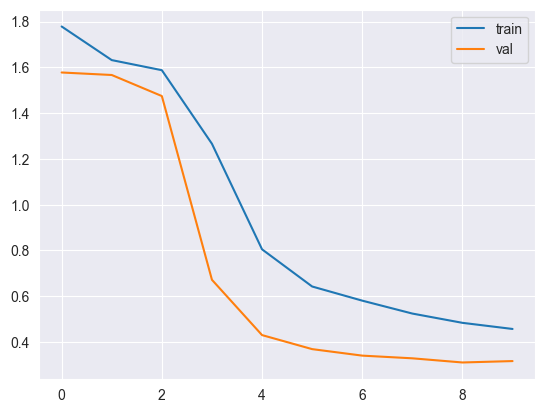

In [4]:
# Training params
n_epochs = 10
train_losses = []
val_losses = []

for _ in tqdm(range(n_epochs)):
    trainer.init_stats_params()
    for source, target, mask in train_dataloader:
        trainer.train_step(source, target, mask)
    train_error = trainer.train_loss/(len(train_dataloader))
    train_losses.append(train_error)
    with torch.no_grad():
        for source, target, mask in validation_dataloader:
            trainer.val_step(source, target, mask)
    val_error = trainer.val_loss/(len(validation_dataloader))
    val_losses.append(val_error)
    
sns.lineplot(train_losses, label="train")
sns.lineplot(val_losses, label="val")
plt.show()

In [5]:
with torch.no_grad(): 
    trainer.init_stats_params()
    for source, target, mask in test_dataloader:
        trainer.val_step(source, target, mask)
    accuracy = 100 * trainer.val_acc / len(test_dataloader.dataset)
    test_loss = trainer.val_loss/(len(test_dataloader))

print(f'Loss: {test_loss:3f}')  # Afficher la perte moyenne
print(f'Accuracy: {accuracy}%')  # Afficher l'accuracy en pourcentage

Loss: 0.289376
Accuracy: 89.2%


In [6]:
torch.save(model.state_dict(), 'models/transformers_model_fn.pth')